In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder

import optuna
from sklearn.model_selection import cross_val_score
from sklearn.metrics import f1_score, make_scorer
from sklearn.linear_model import LogisticRegression

import warnings

# Tüm uyarıları kapat
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv("../data/shopping_istanbul.csv")
df.head()

,invoice_no,customer_id,gender,age,category,quantity,price,payment_method,invoice_date,shopping_mall
0,I138884,C241288,Female,28,Clothing,5,1500.40,Credit Card,5/8/2022,Kanyon
1,I317333,C111565,Male,21,Shoes,3,1800.51,Debit Card,12/12/2021,Forum Istanbul
2,I127801,C266599,Male,20,Clothing,1,300.08,Cash,9/11/2021,Metrocity
3,I173702,C988172,Female,66,Shoes,5,3000.85,Credit Card,16/05/2021,Metropol AVM
4,I337046,C189076,Female,53,Books,4,60.60,Cash,24/10/2021,Kanyon


In [3]:
df.shape

(99457, 10)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99457 entries, 0 to 99456
Data columns (total 10 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   invoice_no      99457 non-null  object 
 1   customer_id     99457 non-null  object 
 2   gender          99457 non-null  object 
 3   age             99457 non-null  int64  
 4   category        99457 non-null  object 
 5   quantity        99457 non-null  int64  
 6   price           99457 non-null  float64
 7   payment_method  99457 non-null  object 
 8   invoice_date    99457 non-null  object 
 9   shopping_mall   99457 non-null  object 
dtypes: float64(1), int64(2), object(7)
memory usage: 7.6+ MB


In [5]:
df.isnull().sum()

invoice_no        0
customer_id       0
gender            0
age               0
category          0
quantity          0
price             0
payment_method    0
invoice_date      0
shopping_mall     0
dtype: int64

In [6]:
df.describe()

,age,quantity,price
count,99457.000000,99457.000000,99457.000000
mean,43.427089,3.003429,689.256321
std,14.990054,1.413025,941.184567
min,18.000000,1.000000,5.230000
25%,30.000000,2.000000,45.450000
50%,43.000000,3.000000,203.300000
75%,56.000000,4.000000,1200.320000
max,69.000000,5.000000,5250.000000


In [7]:
df.select_dtypes(include='object').nunique()

invoice_no        99457
customer_id       99457
gender                2
category              8
payment_method        3
invoice_date        797
shopping_mall        10
dtype: int64

In [8]:
# Sayısal sütunlar
num_cols = df.select_dtypes(include='number').columns

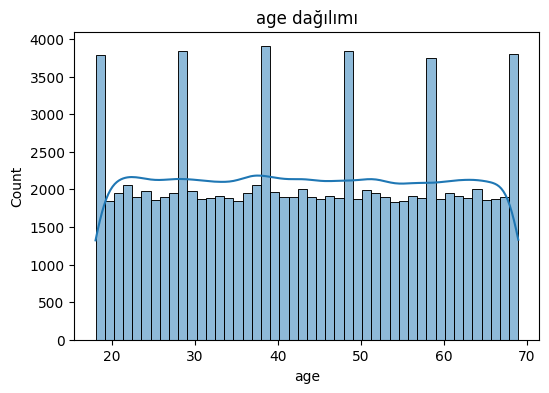

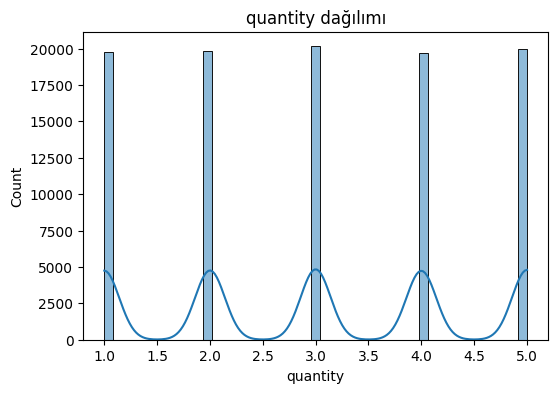

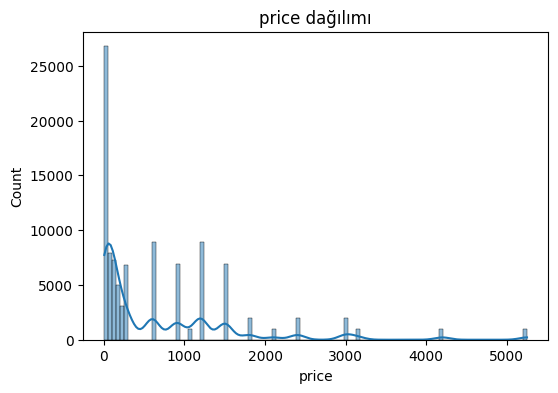

In [9]:
for col in num_cols:
    plt.figure(figsize=(6,4))
    sns.histplot(df[col], kde=True)
    plt.title(f'{col} dağılımı')
    plt.show()

In [10]:
# Kategorik sütunlar
cat_cols = df.select_dtypes(include='object').columns
print(cat_cols)

Index(['invoice_no', 'customer_id', 'gender', 'category', 'payment_method',
       'invoice_date', 'shopping_mall'],
      dtype='object')


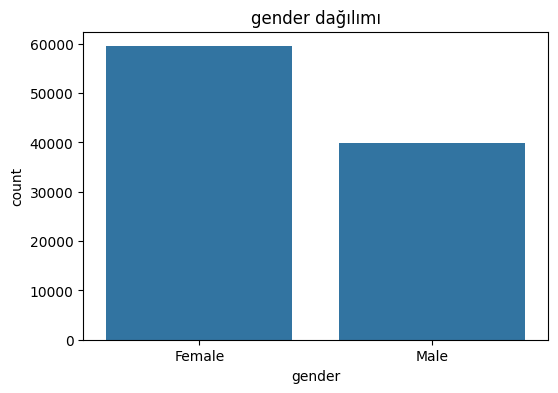

In [11]:
plt.figure(figsize=(6,4))
sns.countplot(x='gender', data=df)
plt.title('gender dağılımı')
plt.show()

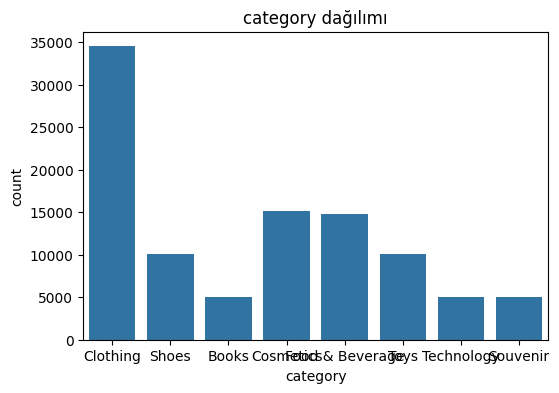

In [12]:
plt.figure(figsize=(6,4))
sns.countplot(x='category', data=df)
plt.title('category dağılımı')
plt.show()

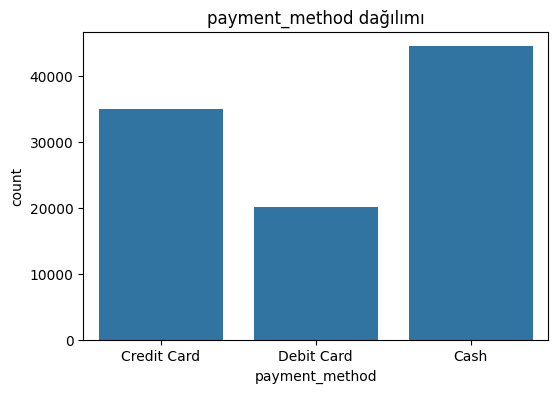

In [13]:
plt.figure(figsize=(6,4))
sns.countplot(x='payment_method', data=df)
plt.title('payment_method dağılımı')
plt.show()

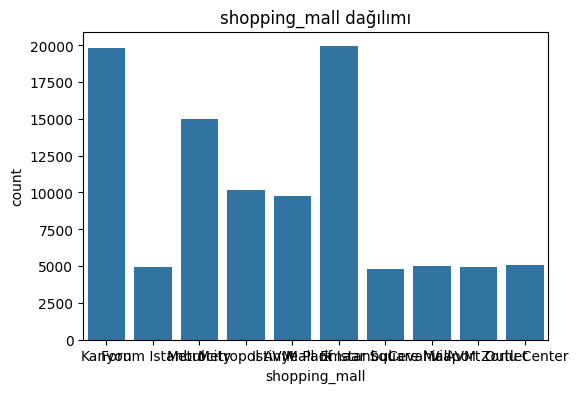

In [14]:
plt.figure(figsize=(6,4))
sns.countplot(x='shopping_mall', data=df)
plt.title('shopping_mall dağılımı')
plt.show()

In [15]:
df.columns

Index(['invoice_no', 'customer_id', 'gender', 'age', 'category', 'quantity',
       'price', 'payment_method', 'invoice_date', 'shopping_mall'],
      dtype='object')

In [16]:
# Harcama sütunu
df['spending'] = df['quantity'] * df['price']

# Harcama seviyeleri: low, medium, high
df['spending_level'] = pd.qcut(df['spending'], q=3, labels=['low','medium','high'])

# Kontrol
df['spending_level'].value_counts()


spending_level
low       33645
medium    33015
high      32797
Name: count, dtype: int64

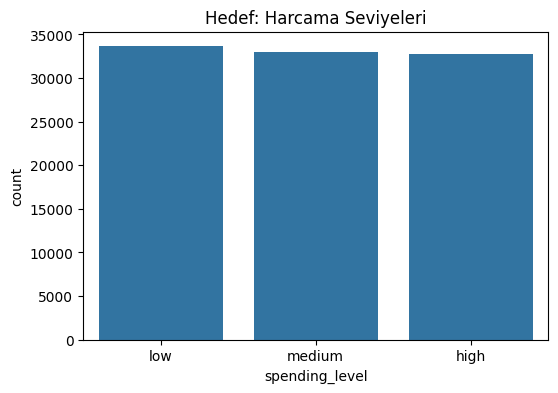

In [17]:
plt.figure(figsize=(6,4))
sns.countplot(x='spending_level', data=df, order=['low','medium','high'])
plt.title('Hedef: Harcama Seviyeleri')
plt.show()

In [37]:
# 1️⃣ Target ve yeni feature'lar
target_col = 'spending_level'

In [38]:
# 2️⃣ Feature Engineering
# Toplam harcama
df['total_spent'] = df['quantity'] * df['price']

In [39]:
# Ortalama harcama
df['avg_price'] = df['total_spent'] / df['quantity']

In [40]:
# Farklı alışveriş mallarında alışveriş sayısı (her müşteri için)
df['mall_variety'] = df.groupby('customer_id')['shopping_mall'].transform('nunique')

In [41]:
df['category_avg_spent'] = df.groupby('category')['total_spent'].transform('mean')

In [42]:
# 3️⃣ Feature list
feature_cols = ['gender', 'age', 'category', 'quantity', 'price', 
                'payment_method', 'shopping_mall', 'total_spent', 
                'avg_price', 'mall_variety', 'category_avg_spent']
X = df[feature_cols]
y = df[target_col]

In [43]:
# 4️⃣ Kategorik değişkenleri encode et
for col in X.select_dtypes(include='object').columns:
    le = LabelEncoder()
    X[col] = le.fit_transform(X[col])

In [44]:
# 5️⃣  Train/Validation split
X_train, X_valid, y_train, y_valid = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

In [45]:
# 6️⃣ Numeric feature’ları scale et
num_cols = ['age', 'quantity', 'price', 'total_spent', 'avg_price', 'mall_variety', 'category_avg_spent']
scaler = StandardScaler()
X_train[num_cols] = scaler.fit_transform(X_train[num_cols])
X_valid[num_cols] = scaler.transform(X_valid[num_cols])

In [46]:
# 7️⃣ Baseline Logistic Regression
le_y = LabelEncoder()
y_train_enc = le_y.fit_transform(y_train)
y_valid_enc = le_y.transform(y_valid)

In [47]:
# 8️⃣ Optuna hyperparameter tuning
def objective(trial):
    C = trial.suggest_float('C', 0.01, 10, log=True)
    solver = 'lbfgs'
    model = LogisticRegression(C=C, solver=solver, max_iter=5000)
    
    score = cross_val_score(
        model, 
        X_train, 
        y_train_enc, 
        cv=3,
        scoring=make_scorer(f1_score, average='weighted')
    ).mean()
    
    return score

In [48]:
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=20)

print("Best params:", study.best_params)

[I 2025-12-09 02:53:16,651] A new study created in memory with name: no-name-34292646-cdaa-409c-8a0a-abdf526f5f78
[I 2025-12-09 02:53:20,175] Trial 0 finished with value: 1.0 and parameters: {'C': 0.0847515948908704}. Best is trial 0 with value: 1.0.
[I 2025-12-09 02:53:25,081] Trial 1 finished with value: 1.0 and parameters: {'C': 4.75384254055968}. Best is trial 0 with value: 1.0.
[I 2025-12-09 02:53:28,010] Trial 2 finished with value: 1.0 and parameters: {'C': 1.0507588628850975}. Best is trial 0 with value: 1.0.
[I 2025-12-09 02:53:30,892] Trial 3 finished with value: 0.9999371567517912 and parameters: {'C': 0.0547732527506755}. Best is trial 0 with value: 1.0.
[I 2025-12-09 02:53:32,992] Trial 4 finished with value: 0.9379395839207566 and parameters: {'C': 0.01718987704109863}. Best is trial 0 with value: 1.0.
[I 2025-12-09 02:53:35,996] Trial 5 finished with value: 0.9900202140094828 and parameters: {'C': 0.03679748969697257}. Best is trial 0 with value: 1.0.
[I 2025-12-09 02:53

Best params: {'C': 0.0847515948908704}


In [49]:
# En iyi parametreyle modeli oluştur
best_model = LogisticRegression(C=0.0847515948908704, solver='lbfgs', max_iter=5000)

# Train set ile eğit
best_model.fit(X_train, y_train_enc)

# Validation set üzerinde tahmin
y_pred_enc = best_model.predict(X_valid)

# Tahminleri orijinal label’a geri çevir
y_pred = le_y.inverse_transform(y_pred_enc)

# Sonuçları göster
print(classification_report(y_valid, y_pred))


              precision    recall  f1-score   support

        high       1.00      1.00      1.00      6560
         low       1.00      1.00      1.00      6729
      medium       1.00      1.00      1.00      6603

    accuracy                           1.00     19892
   macro avg       1.00      1.00      1.00     19892
weighted avg       1.00      1.00      1.00     19892

